In [1]:
%matplotlib inline

import multiprocessing
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from itertools import islice
import os

In [2]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from estimator import PerceiverAREstimator
from pytorch_lightning.loggers import CSVLogger, WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, DeviceStatsMonitor, EarlyStopping


2023-11-15 19:22:45.471435: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-15 19:22:45.515261: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
dataset = get_dataset("electricity")

In [4]:
seed = 0
experiment_name = "perceiverar"
fulldir = experiment_name + "/" + str(seed)
os.makedirs(fulldir, exist_ok=True)


# Code to retrieve the version with the highest #epoch stored and restore it incl directory and its checkpoint
lightning_version_to_use, ckpt_path = None, None
max_epoch = -1
if "perceiverar" in os.listdir(fulldir):
    ckpts = glob(fulldir+ sha1(fulldir.encode("utf-8")).hexdigest()[:8] + "/checkpoints/*.ckpt")
    if len(ckpts): ckpt_path = ckpts[0]
elif "lightning_logs" in os.listdir(fulldir):
    for lightning_version in os.listdir(fulldir+"/lightning_logs/"):
        ckpts = glob(fulldir+"/lightning_logs/" + lightning_version + "/checkpoints/*.ckpt")
        if len(ckpts):
            epoch = int(ckpts[0][ckpts[0].find("=")+1:ckpts[0].find("-step")])
            if epoch > max_epoch:
                lightning_version_to_use = lightning_version
                max_epoch = epoch
                ckpt_path = ckpts[0]
    if lightning_version_to_use: print("Using lightning_version", lightning_version_to_use, "with epoch", max_epoch, "restoring from checkpoint at path", ckpt_path)


experiment_logger = CSVLogger(save_dir=fulldir)
logger = [experiment_logger]
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=50, verbose=True, mode="min")
callbacks=[early_stop_callback]


In [5]:
estimator = PerceiverAREstimator(
    depth=2,
    heads=2,
    # freq=dataset.metadata.freq,
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*10,
    # num_feat_static_cat=1,
    # cardinality=[321],
    # embedding_dimension=[3],

    batch_size=128,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(max_epochs=50, accelerator='gpu', devices=1,),
    ckpt_path = ckpt_path
)


In [6]:
predictor = estimator.train(
    training_data=dataset.train,
    # validation_data=dataset.test,
    # num_workers=8,
    shuffle_buffer_length=1024,
    ckpt_path = ckpt_path
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/ccs/proj/csc499/hstellar/py38/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | PerceiverARModel | 110 K 
-------------------------------------------
110 K     Trainable params
0         Non-trainable params
110 K     Total params
0.441     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'train_loss' reached 6.29438 (best 6.29438), saving model to '/gpfs/alpine/csc499/scratch/hstellar/catch22/pytorch-transformer-ts/perceiverar/lightning_logs/version_3/checkpoints/epoch=0-step=100.ckpt' as top 1
Epoch 1, global step 200: 'train_loss' was not in top 1
Epoch 2, global step 300: 'train_loss' reached 5.62765 (best 5.62765), saving model to '/gpfs/alpine/csc499/scratch/hstellar/catch22/pytorch-transformer-ts/perceiverar/lightning_logs/version_3/checkpoints/epoch=2-step=300.ckpt' as top 1
Epoch 3, global step 400: 'train_loss' was not in top 1
Epoch 4, global step 500: 'train_loss' reached 5.49550 (best 5.49550), saving model to '/gpfs/alpine/csc499/scratch/hstellar/catch22/pytorch-transformer-ts/perceiverar/lightning_logs/version_3/checkpoints/epoch=4-step=500.ckpt' as top 1
Epoch 5, global step 600: 'train_loss' reached 5.44740 (best 5.44740), saving model to '/gpfs/alpine/csc499/scratch/hstellar/catch22/pytorch-transformer-ts/perceiverar/lightning

In [7]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor
)

In [8]:
forecasts = list(forecast_it)

In [9]:
tss = list(ts_it)

In [10]:
# num_workers is limited to 10 if cpu has more cores
num_workers = min(multiprocessing.cpu_count(), 10)

evaluator = Evaluator(num_workers=num_workers)
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation: 100%|██████████| 2247/2247 [00:00<00:00, 11527.87it/s]
/ccs/proj/csc499/hstellar/py38/lib/python3.8/site-packages/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/ccs/proj/csc499/hstellar/py38/lib/python3.8/site-packages/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/ccs/proj/csc499/hstellar/py38/lib/python3.8/site-packages/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/ccs/proj/csc499/hstellar/py38/lib/python3.8/site-packages/pandas/core/dtypes/astype.py:170: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [11]:
agg_metrics

{'MSE': 1485366.7999120897,
 'abs_error': 7628441.005818844,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.6732626900142408,
 'MAPE': 0.09598455031189793,
 'sMAPE': 0.09841803549623794,
 'MSIS': 5.379909961550135,
 'QuantileLoss[0.1]': 3199871.026954667,
 'Coverage[0.1]': 0.10005933837709538,
 'QuantileLoss[0.2]': 5091468.644947461,
 'Coverage[0.2]': 0.2177162142115413,
 'QuantileLoss[0.3]': 6373714.559930385,
 'Coverage[0.3]': 0.3367082035306334,
 'QuantileLoss[0.4]': 7213336.249873614,
 'Coverage[0.4]': 0.44889482272659836,
 'QuantileLoss[0.5]': 7628440.970053031,
 'Coverage[0.5]': 0.553293279928794,
 'QuantileLoss[0.6]': 7622237.556184668,
 'Coverage[0.6]': 0.6415776591010236,
 'QuantileLoss[0.7]': 7131255.174900597,
 'Coverage[0.7]': 0.735387924640261,
 'QuantileLoss[0.8]': 6030339.210479933,
 'Coverage[0.8]': 0.8218736092567869,
 'QuantileLoss[0.9]': 4044796.7381556076,
 'Coverage[0.9]': 0.9057817831182317,

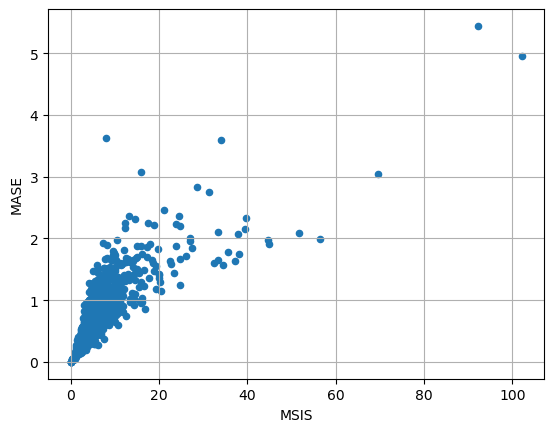

In [12]:
ts_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

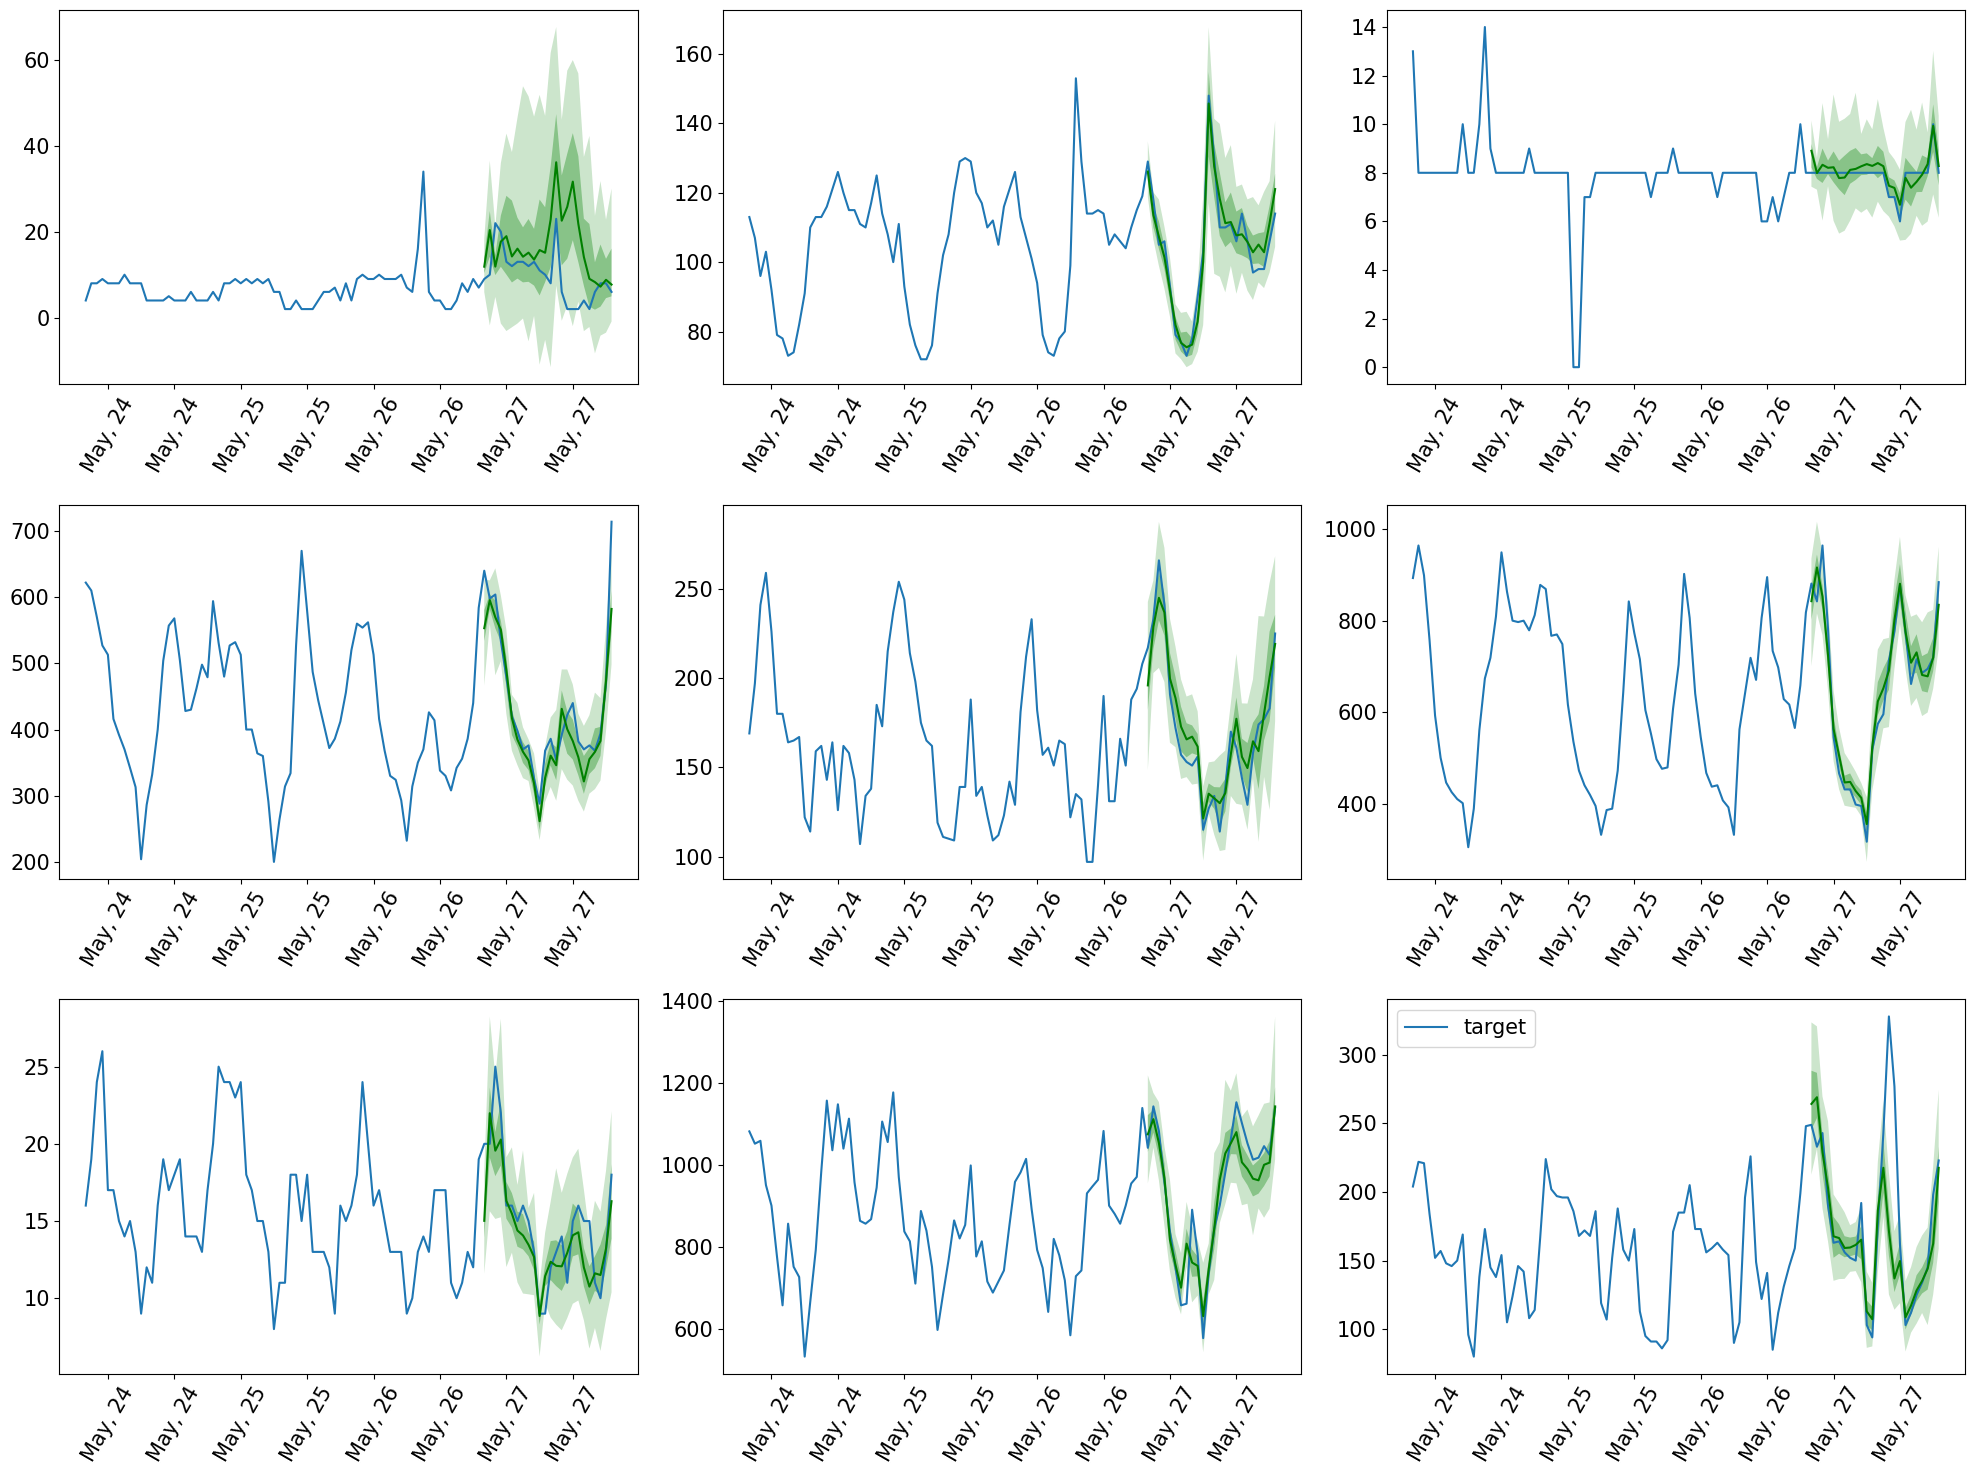

In [13]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    # Convert index for plot
    ts = ts[-4 * dataset.metadata.prediction_length:].to_timestamp()
    
    plt.plot(ts, label="target")    
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()